# This notebook serves as a testbed for the ABSA pipeline before we actually create scripts and a working pipeline.

In [1]:
# !python -m spacy download en_core_web_sm

## Load data and clean

In [2]:
import pandas as pd 

post_data = pd.read_csv('../data/posts_sentiment.csv')
post_data.shape

(448, 11)

In [3]:
post_data.head(5)

,Unnamed: 0,id,date,title,content,username,commentCount,score,subreddit,Code,sentiment
0,0,absdf,2019-08-03 11:27:29,中国产C919飞机有一大缺点 难获国际市场,中国C919飞机原定于去年年底交付。虽然在今年5月完成了即将交付用户的首架飞机的试飞，但还没...,xl,0,0,SouthwestAirlines,WN,NEUTRAL
1,1,1g7qgpv,2024-10-20 12:04:51,Question/Help,"Hey everyone, I know it’s a long shot, but I t...",Kmelloww,4,0,SouthwestAirlines,WN,NEGATIVE
2,2,1g7plv5,2024-10-20 11:12:20,Airpods left on plane,I left my airpods on a recent flight and I can...,Ph4Nt0M218,6,3,SouthwestAirlines,WN,NEGATIVE
3,4,1g7o4ce,2024-10-20 09:44:42,"If I book 4 tickets together and I’m A-List, w...",I know all the tickets in my booking get my bo...,DoubleJob6790,3,3,SouthwestAirlines,WN,NEUTRAL
4,5,1g7nqmh,2024-10-20 09:23:06,"Elliott, Southwest Airlines to begin settlemen...",Interesting,Even-Compote2602,9,20,SouthwestAirlines,WN,POSITIVE


In [4]:
# Filtering non-english posts
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 42

def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

In [5]:
# Preprocessing text
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove whitespaces
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kengb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
test_data = post_data[post_data['content'].apply(is_english)]
# combine title with content
test_data['content'] = test_data['title'] + ' ' + test_data['content']
test_data['content'] = test_data['content'].apply(preprocess_text)
test_data.shape

C:\Users\kengb\AppData\Local\Temp\ipykernel_23416\4228701406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['content'] = test_data['title'] + ' ' + test_data['content']
C:\Users\kengb\AppData\Local\Temp\ipykernel_23416\4228701406.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['content'] = test_data['content'].apply(preprocess_text)


(440, 11)

In [7]:
# Sanity check

test_data = test_data.drop(columns=['Unnamed: 0', 'title', 'username', 'commentCount', 'score', 'subreddit', 'Code', 'sentiment'])
test_data = test_data.reset_index(drop=True)
test_data.head(5)

,id,date,content
0,1g7qgpv,2024-10-20 12:04:51,questionhelp hey everyone know long shot thoug...
1,1g7plv5,2024-10-20 11:12:20,airpods left plane left airpods recent flight ...
2,1g7o4ce,2024-10-20 09:44:42,book tickets together im alist confirmed day c...
3,1g7nqmh,2024-10-20 09:23:06,elliott southwest airlines begin settlement di...
4,1g7no5o,2024-10-20 09:19:10,silly question app booked flights downloaded a...


## Aspect Extraction
Getting the subjects / aspects / topics in the text to extract sentiments about later. Using Latent Dirichlet Allocation (LDA).

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(test_data['content'])
vectorizer.get_feature_names_out()

array(['aa', 'aa flight', 'able', 'able get', 'accept', 'account',
       'across', 'actually', 'added', 'additional', 'advance', 'advice',
       'agency', 'agent', 'agents', 'ago', 'ahead', 'air', 'aircraft',
       'airline', 'airlines', 'airlines customer', 'airlines flight',
       'airport', 'airports', 'aisle', 'alaska', 'alaska airlines',
       'alist', 'allow', 'allowed', 'almost', 'alone', 'along', 'already',
       'also', 'although', 'always', 'american', 'american airlines',
       'americanair', 'amex', 'amount', 'another', 'another airline',
       'another flight', 'answer', 'anyone', 'anyone else',
       'anyone experience', 'anyone know', 'anything', 'anyway',
       'anyways', 'app', 'apparently', 'application', 'applied', 'apply',
       'appreciated', 'approved', 'area', 'around', 'arrival', 'arrive',
       'arrived', 'ask', 'asked', 'asking', 'assigned',
       'assigned seating', 'assigned seats', 'assignments', 'athens',
       'atl', 'atlanta', 'atlantic', '

In [9]:
# 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

topics = lda_model.components_
feature_names = vectorizer.get_feature_names_out()

for idx, topic in enumerate(topics):
    print(f'Topic {idx}:')
    print([feature_names[i] for i in topic.argsort()[-10:]])
    print()

Topic 0:
['wild', 'seat', 'seattle', 'go wild', 'password', 'orlando', 'first', 'wifi', 'class', 'first class']

Topic 1:
['gate', 'bag', 'carry', 'airlines', 'plane', 'aa', 'alaska', 'hawaiian', 'flight', 'seat']

Topic 2:
['bring', 'weight', 'flight', 'personal', 'jfk', 'anyone', 'airlines', 'item', 'personal item', 'southwest']

Topic 3:
['ticket', 'miles', 'time', 'credit', 'card', 'flights', 'delta', 'im', 'get', 'flight']

Topic 4:
['schedule', 'baggage', 'car seat', 'item', 'application', 'lost', 'need', 'starlink', 'carryon', 'car']



In [10]:
document_topics = lda_model.transform(X)
dominant_topics = document_topics.argmax(axis=1)
dominant_topics

array([3, 3, 3, 2, 3, 3, 0, 2, 3, 0, 3, 3, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3,
       1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3,
       3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 1, 3, 1, 3, 2, 3, 4, 1, 3, 3, 0, 3, 3, 3, 1, 3, 4, 1, 3, 1,
       3, 1, 0, 1, 4, 4, 1, 0, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 4, 3,
       3, 3, 3, 3, 1, 3, 1, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 1,
       1, 3, 1, 3, 3, 1, 3, 4, 0, 1, 3, 1, 3, 3, 1, 3, 4, 2, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 4, 1, 3, 0, 1, 3, 3, 1, 3, 1, 0, 1,
       3, 1, 3, 3, 4, 3, 3, 4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 2, 1, 3, 1, 1,
       3, 3, 2, 2, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 4, 3, 3, 2,
       3, 3, 2, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 4, 3, 1, 1,
       3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3,

In [11]:
# Get GPT to generate a title for each topic
import collections
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
import os
import openai

load_dotenv()
topic_dict = collections.defaultdict(list)
openai_model = openai.OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

for idx, topic in enumerate(topics):
    print(f'Topic {idx}:')
    
    top_features = [feature_names[i] for i in topic.argsort()[-50:]]
    print(top_features)
    # feed chatgpt the words and generate a title
    prompt = f"""Generate a unique noun phrase or one-word topic for posts that contain the following features. 
    This topic will be used for Aspect-Based Sentiment Analysis on social media data. 
    Ensure the topic is different from previously generated topics. 
    Feature names:\n{", ".join(top_features)}\nTopic:"""
    prompt = PromptTemplate.from_template(prompt)
    response = openai_model.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt.template}],
        max_tokens=10,
        temperature=1,
    )
    print(response.choices[0].message.content)
    title = response.choices[0].message.content.strip()
    # if there are repeated topics, add an index to the title
    if title in topic_dict:
        title = title + "_" + str(idx)
    topic_dict[title] = [feature_names[i] for i in topic.argsort()]
print(topic_dict.keys())

Topic 0:
['id', 'instead', 'reservations', 'best', 'exactly', 'mco', 'stolen', 'difference', 'trips', 'group', 'vegas', 'destinations', 'top', 'link', 'seating', 'las', 'las vegas', 'anyone', 'open', 'skyclub', 'ones', 'trying get', 'seats', 'lounge', 'update', 'american', 'often', 'whats', 'economy', 'fault', 'philadelphia', 'seat assignments', 'assignments', 'look', 'uplift', 'oakland', 'wild pass', 'st', 'go', 'domestic', 'wild', 'seat', 'seattle', 'go wild', 'password', 'orlando', 'first', 'wifi', 'class', 'first class']
"Travel Seat Dynamics"
Topic 1:
['hawaii', 'big', 'shit', 'american', 'never', 'hold', 'board', 'us', 'hi', 'going', 'gold', 'got', 'group', 'like', 'international', 'staff', 'question', 'customer', 'checked', 'people', 'didnt', 'hawaiian airlines', 'frontier', 'airport', 'pilots', 'agent', 'flying', 'status', 'said', 'would', 'anyone', 'swa', 'crew', 'free', 'check', 'delta', 'know', 'im', 'get', 'boarding', 'gate', 'bag', 'carry', 'airlines', 'plane', 'aa', 'alas

## Sentiment Analysis

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_model = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = vader_model.polarity_scores(text)
    return sentiment['compound']

## ABSA

In [13]:
for idx, row in test_data.iterrows():
    text = row['content']
    sentiment = get_sentiment(text)
    test_data.at[idx, 'sentiment'] = sentiment
    test_data.at[idx, 'topic'] = list(topic_dict.keys())[dominant_topics[idx]]

test_data.head(5)

,id,date,content,sentiment,topic
0,1g7qgpv,2024-10-20 12:04:51,questionhelp hey everyone know long shot thoug...,0.9274,"""Aviation Journey Experiences"""
1,1g7plv5,2024-10-20 11:12:20,airpods left plane left airpods recent flight ...,-0.4215,"""Aviation Journey Experiences"""
2,1g7o4ce,2024-10-20 09:44:42,book tickets together im alist confirmed day c...,0.7906,"""Aviation Journey Experiences"""
3,1g7nqmh,2024-10-20 09:23:06,elliott southwest airlines begin settlement di...,0.4019,"""Airline Experience Insights"""
4,1g7no5o,2024-10-20 09:19:10,silly question app booked flights downloaded a...,0.9262,"""Aviation Journey Experiences"""


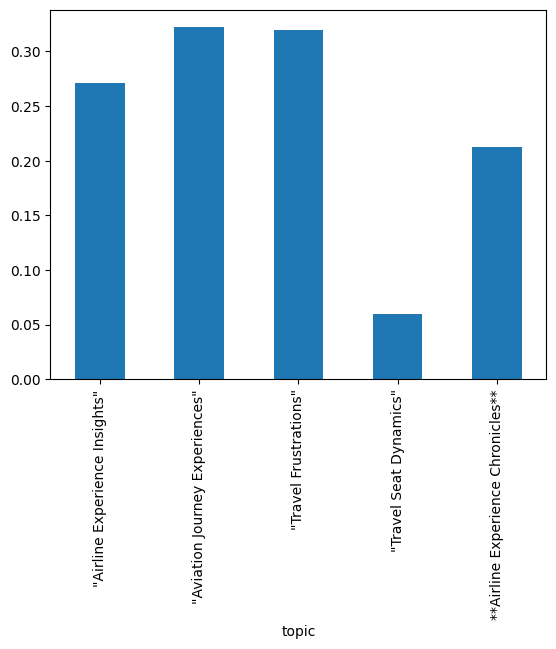

In [15]:
import matplotlib.pyplot as plt
sentiment_summary = test_data.groupby('topic')['sentiment'].mean()
sentiment_summary.plot(kind='bar')
plt.show()

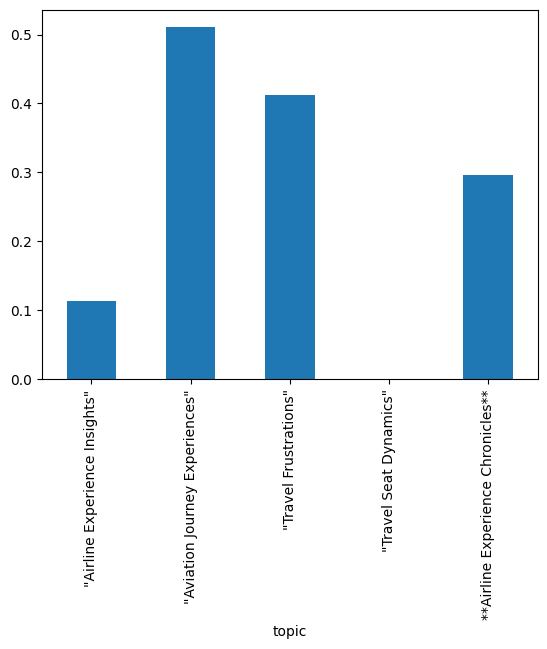

In [16]:
sentiment_summary = test_data.groupby('topic')['sentiment'].median()
sentiment_summary.plot(kind='bar')
plt.show()

## Saving Files

In [17]:
import pickle

with open('../models/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

In [18]:
with open('../models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)